# **Use case 1: Quick and Easy - FastSurfer Segmentation with three clicks**


## Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

### Cookies

Make sure your Browser allows third-party cookies

 - [Firefox](https://support.mozilla.org/en-US/kb/third-party-cookies-firefox-tracking-protection)
 - [Google Chrome](https://support.google.com/chrome/answer/95647?hl=en&co=GENIE.Platform=Desktop#zippy=%2Callow-or-block-cookies)

---

## Click 1: Setup FastSurfer

In [ ]:
#@title Here we first setup the enviroment by downloading the open source deep-mi/fastsurfer project and the required packages
import os
import sys
from os.path import exists, join, basename, splitext

print("Starting setup. This could take a few minutes")
print("----------------------------------------------")

print("downloading fastsurfer")
print("----------------------------------------------")

git_repo_url = 'https://github.com/deep-mi/fastsurfer.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q $git_repo_url
  sys.path.append(project_name)

# Go to the FastSurfer directory
%cd /content/fastsurfer/

# Update dependencies
print("installing required packages")
print("----------------------------------------------")

! pip install torchio==0.18.83
! pip install yacs==0.1.8

print("Finished setup")
print("----------------------------------------------")

---

## Click 2: Upload your image

In [ ]:
#@title Click the run button to upload your T1-weighted MRI image (will be deleted after the session is over; make sure you have the permissions to do this for the image in question).
from google.colab import files
! cd "/content"
uploaded = files.upload()

img = "/content/" + list(uploaded.keys())[0]

In [ ]:
#@title Alternative: Click the run button to download an example subject from the internet (e.g. FreeSurfer Tutorial data)
!curl -k https://surfer.nmr.mgh.harvard.edu/pub/data/tutorial_data/buckner_data/tutorial_subjs/140/mri/orig.mgz -o /content/140_orig.mgz
img = "/content/140_orig.mgz"

---

## Click 3: Run FastSurfer

In [ ]:
#@title The first part of FastSurfer creates a whole-brain segmentation into 95 classes. Here, we use the pretrained deep-learning network FastSurferCNN using the checkpoints stored at the open source project deep-mi/fastsurfer to to run the model inference on a single image.

! ./run_fastsurfer.sh --t1 $img \
                      --sd /content/fastsurfer_seg \
                      --sid Tutorial \
                      --seg_only --py python3 \
                      --allow_root

Setting ENV variable FASTSURFER_HOME to current working directory /content/fastsurfer. 
Change via enviroment to location of your choice if this is undesired (export FASTSURFER_HOME=/dir/to/FastSurfer)
Mon Jan  2 15:52:32 UTC 2023

python3 /content/fastsurfer/FastSurferCNN/run_prediction.py --t1 /content/140_orig.mgz --aparc_aseg_segfile /content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.mgz --conformed_name /content/fastsurfer_seg/Tutorial/mri/orig.mgz --sid Tutorial --seg_log /content/fastsurfer_seg/Tutorial/scripts/deep-seg.log --vox_size min --batch_size 1 --viewagg_device auto --device auto --allow_root
[INFO: run_prediction.py:  340]: Checking or downloading default checkpoints ...
[INFO: run_prediction.py:  158]: Output will be stored in: /content/fastsurfer_seg
[INFO: misc.py:  159]: Using device: cuda
[INFO: run_prediction.py:  121]: Running view aggregation on cuda
[INFO: inference.py:   95]: Loading checkpoint /content/fastsurfer/FastSurferCNN/checkpoints/aparc_vi

---

## Click 4: Download the image

In [ ]:
#@title Click the run button to download the image to a destination of your choice
files.download('/content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.mgz')

In [ ]:
#@title Click this run button, if you would prefer to download the segmentation in nifti-format
import nibabel as nib
# conversion to nifti
data = nib.load('/content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.mgz')
img_nifti = nib.Nifti1Image(data.get_fdata(), data.affine, header=nib.Nifti1Header())
nib.nifti1.save(img_nifti, '/content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.nii.gz')

from google.colab import files
files.download('/content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.nii.gz')

In [ ]:
#@title If you chose the example subject (Alternative in Click 1), click the run button if you want to download the input image as well
from google.colab import files
files.download("/content/140_orig.mgz")

In [ ]:
#@title Click this run button, if you would prefer to download the image in nifti-format
import nibabel as nib
# conversion to nifti
data = nib.load("/content/140_orig.mgz")
img_nifti = nib.Nifti1Image(data.get_fdata(), data.affine, header=nib.Nifti1Header())
nib.nifti1.save(img_nifti, "/content/140_orig.nii.gz")

from google.colab import files
files.download("/content/140_orig.nii.gz")


---

# Done! 

Congratulations. You succesfully segmented your image into 95 classes :). You can now inspect the segmentation with a neuroimaging viewer of your choice or use the widgets below to get a first impression of your segmentation (in-line visualizations). 

For a more advanced notebook with indepth explanations and further processing options see: https://colab.research.google.com/github/Deep-MI/FastSurfer/blob/stable/Tutorial/Complete_FastSurfer_Tutorial.ipynb

---

### In-line visualizations

<ipython-input-7-d34987171c40>:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


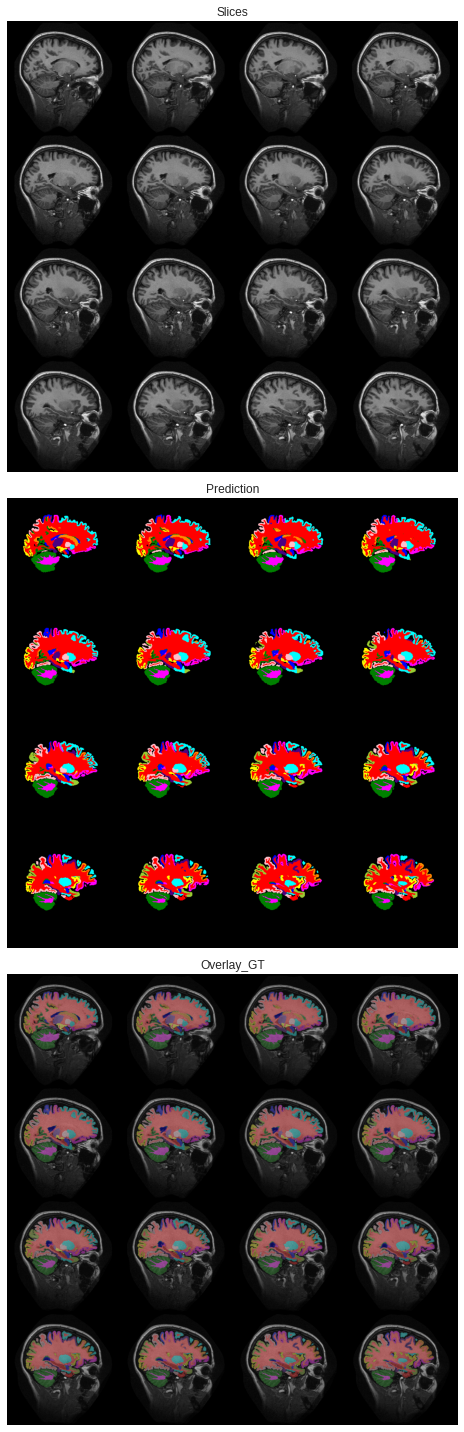

In [ ]:
#@title Click the run buttion to plot some slices from the segmented brain
%matplotlib inline
import nibabel as nib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from skimage import color
import torch
import numpy as np
from torchvision import utils

def plot_predictions(image, pred):
    """
    Function to plot predictions from validation set.
    :param images_batch:
    :param labels_batch:
    :param batch_output:
    :param plt_title:
    :param file_save_name:
    :return:
    """

    f = plt.figure(figsize=(20, 20))
    n, h, w = image.shape

    mid_slice = n // 2
    image = torch.from_numpy(np.expand_dims(image[mid_slice+16:mid_slice+32, :, :], 1))
    grid = utils.make_grid(image, nrow=4)

    plt.subplot(311)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Slices')

    grid2 = utils.make_grid(torch.from_numpy(np.expand_dims(pred[mid_slice+16:mid_slice+32, ...], 1)), nrow=4)[0]
    color_grid = color.label2rgb(grid2.numpy(), bg_label=0)
    plt.subplot(312)
    plt.imshow(color_grid)
    plt.title('Prediction')

    plt.subplot(313)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.imshow(color_grid, alpha=0.3)
    plt.title('Overlay_GT')

    for ax in f.axes:
      ax.grid(b=None)
      ax.axis("off")
    plt.tight_layout()

    plt.show()

orig_data = nib.load(img).get_fdata() / 255
pred_data = nib.load('/content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.mgz').get_fdata()
plot_predictions(orig_data, pred_data)

In [ ]:
#@title Select and visualize your structures of interest in 3D by using the dropdown menu and clicking "Run Interact". 
from ipywidgets import widgets
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

pred_data = nib.load('/content/fastsurfer_seg/Tutorial/mri/aparc.DKTatlas+aseg.deep.mgz').get_fdata()

labels = [
'Lateral-Ventricle',
'Inf-Lat-Vent',
'Cerebellum-White-Matter',
'Cerebellum-Cortex',
'Thalamus-Proper',
'Caudate',
'Putamen',
'Pallidum',
'3rd-Ventricle',
'4th-Ventricle',
'Brain-Stem',
'Hippocampus',
'Amygdala',
'CSF',
'Accumbens-area',
'VentralDC',
'choroid-plexus',
'caudalanteriorcingulate',
'caudalmiddlefrontal',
'cuneus',
'entorhinal',
'fusiform',
'inferiorparietal',
'inferiortemporal',
'isthmuscingulate',
'lateraloccipital',
'lateralorbitofrontal',
'lingual',
'medialorbitofrontal',
'middletemporal',
'parahippocampal',
'paracentral',
'parsopercularis',
'parsorbitalis',
'parstriangularis',
'pericalcarine',
'postcentral',
'posteriorcingulate',
'precentral',
'precuneus',
'rostralanteriorcingulate',
'rostralmiddlefrontal',
'superiorfrontal',
'superiorparietal',
'superiortemporal',
'supramarginal',
'transversetemporal',
'insula']

labels_lookup = {
'Left-Lateral-Ventricle': 4,
'Left-Inf-Lat-Vent': 5,
'Left-Cerebellum-White-Matter': 7,
'Left-Cerebellum-Cortex': 8,
'Left-Thalamus-Proper': 10,
'Left-Caudate': 11,
'Left-Putamen': 12,
'Left-Pallidum': 13,
'Left-3rd-Ventricle': 14,
'Left-4th-Ventricle': 15,
'Left-Brain-Stem': 16,
'Left-Hippocampus': 17,
'Left-Amygdala': 18,
'Left-CSF': 24,
'Left-Accumbens-area': 26,
'Left-VentralDC': 28,
'Left-choroid-plexus': 31,
'Right-Lateral-Ventricle': 43,
'Right-Inf-Lat-Vent': 44,
'Right-Cerebellum-White-Matter': 46,
'Right-Cerebellum-Cortex': 47,
'Right-Thalamus-Proper': 49,
'Right-Caudate': 50,
'Right-Putamen': 51,
'Right-Pallidum': 52,
'Right-Hippocampus': 53,
'Right-Amygdala': 54,
'Right-Accumbens-area': 58,
'Right-VentralDC': 60,
'Right-choroid-plexus': 63,
'Right-3rd-Ventricle': 14,
'Right-4th-Ventricle': 15,
'Right-Brain-Stem': 16,
'Right-CSF': 24,
'ctx-lh-caudalanteriorcingulate': 1002,
'ctx-lh-caudalmiddlefrontal': 1003,
'ctx-lh-cuneus': 1005,
'ctx-lh-entorhinal': 1006,
'ctx-lh-fusiform': 1007,
'ctx-lh-inferiorparietal': 1008,
'ctx-lh-inferiortemporal': 1009,
'ctx-lh-isthmuscingulate': 1010,
'ctx-lh-lateraloccipital': 1011,
'ctx-lh-lateralorbitofrontal': 1012,
'ctx-lh-lingual': 1013,
'ctx-lh-medialorbitofrontal': 1014,
'ctx-lh-middletemporal': 1015,
'ctx-lh-parahippocampal': 1016,
'ctx-lh-paracentral': 1017,
'ctx-lh-parsopercularis': 1018,
'ctx-lh-parsorbitalis': 1019,
'ctx-lh-parstriangularis': 1020,
'ctx-lh-pericalcarine': 1021,
'ctx-lh-postcentral': 1022,
'ctx-lh-posteriorcingulate': 1023,
'ctx-lh-precentral': 1024,
'ctx-lh-precuneus': 1025,
'ctx-lh-rostralanteriorcingulate': 1026,
'ctx-lh-rostralmiddlefrontal': 1027,
'ctx-lh-superiorfrontal': 1028,
'ctx-lh-superiorparietal': 1029,
'ctx-lh-superiortemporal': 1030,
'ctx-lh-supramarginal': 1031,
'ctx-lh-transversetemporal': 1034,
'ctx-lh-insula': 1035,
'ctx-rh-caudalanteriorcingulate': 2002,
'ctx-rh-caudalmiddlefrontal': 2003,
'ctx-rh-cuneus': 2005,
'ctx-rh-entorhinal': 2006,
'ctx-rh-fusiform': 2007,
'ctx-rh-inferiorparietal': 2008,
'ctx-rh-inferiortemporal': 2009,
'ctx-rh-isthmuscingulate': 2010,
'ctx-rh-lateraloccipital': 2011,
'ctx-rh-lateralorbitofrontal': 2012,
'ctx-rh-lingual': 2013,
'ctx-rh-medialorbitofrontal': 2014,
'ctx-rh-middletemporal': 2015,
'ctx-rh-parahippocampal': 2016,
'ctx-rh-paracentral': 2017,
'ctx-rh-parsopercularis': 2018,
'ctx-rh-parsorbitalis': 2019,
'ctx-rh-parstriangularis': 2020,
'ctx-rh-pericalcarine': 2021,
'ctx-rh-postcentral': 2022,
'ctx-rh-posteriorcingulate': 2023,
'ctx-rh-precentral': 2024,
'ctx-rh-precuneus': 2025,
'ctx-rh-rostralanteriorcingulate': 2026,
'ctx-rh-rostralmiddlefrontal': 2027,
'ctx-rh-superiorfrontal': 2028,
'ctx-rh-superiorparietal': 2029,
'ctx-rh-superiortemporal': 2030,
'ctx-rh-supramarginal': 2031,
'ctx-rh-transversetemporal': 2034,
'ctx-rh-insula': 2035}

def label_lookups(structure, hemi):
  # determine what to plot
  if structure[0].isupper():
    if hemi == "left":
      label = labels_lookup["Left-" + structure]
    elif hemi == "right":
      label = labels_lookup["Right-" + structure]
    else:
      label = [labels_lookup["Left-" + structure], labels_lookup["Right-" + structure]]
  else:
    if hemi == "left":
      label = labels_lookup["ctx-lh-" + structure]
    elif hemi == "right":
      label = labels_lookup["ctx-rh-" + structure]
    else:
      label = [labels_lookup["ctx-lh-" + structure], labels_lookup["ctx-rh-" + structure]]
  return label

@widgets.interact_manual(
    hemisphere=['left', 'right', 'both'], structure=labels)
def plot_3d_plotly_shape(structure, hemisphere, show_mesh=True, crop=True, grid=True):
  import plotly.graph_objects as go
  label = label_lookups(structure, hemisphere)
  test_cond = np.in1d(pred_data, label).reshape(pred_data.shape)
  roi = np.where(test_cond, 1, 0)
  vert_p, faces_p, normals_p, values_p = measure.marching_cubes(roi, 0, spacing=(1, 1, 1))

  fig = go.Figure(data=[go.Mesh3d(
        x=vert_p[:, 0],
        y=vert_p[:, 1],
        z=vert_p[:, 2],
        # i, j and k give the vertices of triangles
        # here we represent the 4 triangles of the tetrahedron surface
        i=faces_p[:, 0],
        j=faces_p[:, 1],
        k=faces_p[:, 2],
        name='y',
        showscale=True
    )]
  )

  if show_mesh:
    #plot surface triangulation
    tri_vertices = vert_p[faces_p]
    Xe = []
    Ye = []
    Ze = []
    
    for T in tri_vertices:
      Xe += [T[k%3][0] for k in range(4)] + [ None]
      Ye += [T[k%3][1] for k in range(4)] + [ None]
      Ze += [T[k%3][2] for k in range(4)] + [ None]
       
    fig.add_trace(go.Scatter3d(x=Xe,
                     y=Ye,
                     z=Ze,
                     mode='lines',
                     name='',
                     line=dict(color= 'rgb(40,40,40)', width=0.5)))
  if crop:
    scale_min = np.min(vert_p, axis=0)
    scale_max = np.max(vert_p, axis=0)
  else:
    scale_min = [0, 0, 0]
    scale_max = pred_data.shape
  fig.update_layout(
    scene = dict(aspectratio=dict(x=1, y=1, z=1),
        xaxis = dict(range=[scale_min[0], scale_max[0]], visible=grid),
        yaxis = dict(range=[scale_min[1], scale_max[1]], visible=grid),
        zaxis = dict(range=[scale_min[2], scale_max[2]], visible=grid),) 
    )

  fig.show()



If the widget is disabled (you are not able to select anything), simply press the play button next to the header.

You can use your mouse to zoom in and out as well as rotate the generated mesh to get a better look at the segmentation. 

To display the surface mesh (edges), check the box "show_mesh" (done by default). A plotting grid can be enabled by checking the box "grid". Checking the box "crop" will automatically adjust the field of view to the range of the ROI. Unchecking it scales the presentation to the dimension of the original scan.
